In [20]:
%matplotlib inline

In [21]:
#@title
import jax
import numpy as np

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

try:
  import flax
except ModuleNotFoundError:
  !pip install --quiet flax==0.6.4
  import flax

try:
  import optax
except ModuleNotFoundError:
  !pip install --quiet optax
  import optax

from flax import linen as nn
from flax.training import train_state

from tqdm import trange
from functools import partial
from matplotlib import pyplot as plt

# Diffusion models

## Intro
For every object in our data distribution $\mu^i \sim p_{\text{data}}(\mu)$ we define the noising process as
$$q_t^i(x) = \mathcal{N}(x|\alpha_t\mu^i,\sigma_t^2)\,.$$
The important part about defining this process is that we know the vector field satisfying the corresponding continuity equation
$$v_t^i(x) = (x-\alpha_t\mu^i)\frac{\partial}{\partial t}\log\sigma_t + \frac{\partial\alpha_t}{\partial t}\mu^i\,.$$
For the entire dataset we can write down the following marginal density
$$q_t(x) = \int \mathcal{N}(x|\alpha_t\mu,\sigma_t^2)p_{\text{data}}(\mu)d\mu\,,$$
and we can write down the loss for the vector field as
$$\text{Loss} = \frac{1}{N}\sum_{i=1}^N\int dt\;\int dx\;\Vert v_t(x;\theta) - v_t^i(x)\Vert^2\,,$$
where $\theta$ are the parameters of our model.

After training, we can simulate the process (generate data) via the following ODE
$$\frac{dx}{dt} = v_t(x)\,,\;\;\; v_t(x) = x\frac{\partial}{\partial t}\log\alpha_t - \beta_t\nabla_x\log q_t(x)\,,\;\;\beta_t = \sigma_t^2\frac{\partial}{\partial t}\log \frac{\sigma_t}{\alpha_t}\,,$$
or SDE
$$dx = (v_t(x) + \xi_t\nabla_x\log q_t(x))\cdot dt + \sqrt{2\xi_t}dW_t\,.$$

## Data Generation

$p_{\text{data}}(\mu)$ is just a mixture of four Gaussians. Then we define the noising process
$$q_t^i(x) = \mathcal{N}(x|\alpha_t\mu^i,\sigma_t^2)\,.$$
See code for $\alpha_t, \sigma_t$.
The plots represent samples from the following marginals for different times $t$
$$q_t(x) = \int \mathcal{N}(x|\alpha_t\mu,\sigma_t^2)p_{\text{data}}(\mu)d\mu\,.$$

This function generates synthetic 2D data from a mixture of 4 Gaussians, centered on the four corners of a 2x2 grid: 

$$ x \textasciitilde \Sigma_{k=1}^4 \pi_k \cdot \mathcal{N}(\mu_k, \Sigma_k)  $$

- $\pi = \dfrac{1}{4}$: Equal probability for each Gaussian
- $\mu_k$: cluster centers (2D Coordinates)
- $\Sigma_k = \sigma^2 I$: same isotropic variance for all

#### 1. Discrete Sampling of Cluster Centers
First, we sample from 4 discrete centers: (0,0), (0,1), (1,0), (1,1).

Start with grid coordinates:
\begin{aligned}
\mathcal{C} = \{ (0,0), (0,1), (1,0), (1,1) \}
\end{aligned}
Each point is a mean $\mu_k$ for the $k$-th Gaussian.

#### 2. Scale and shift the centers
To make clusters spread out visually:
- \bold{Scale}: Multiply coordinates by a factor (e.g 3)
- \bold{Shift}: Center around origin (e.g subtract 1.5)

\begin{aligned}
  \mu_k = 3 \cdot (i,j) - 1.5 
\end{aligned} 

This maps the grid to:
\begin{aligned}
\{ (−1.5,−1.5),(−1.5,1.5),(1.5,−1.5),(1.5,1.5) \}
\end{aligned}

#### 3. Sample From Each Gaussian
For a chosen center $\mu_k$ sample:
\begin{aligned}
   x \textasciitilde \mathcal{N}(\mu_k, \sigma^2 I)
\end{aligned}
This generates points clustered around that center with isotropic spread



In [22]:
from typing import NamedTuple, Any
def sample_data(key, bs):
  keys = random.split(key, 3)
  x_1 = random.randint(keys[0], minval=0, maxval=2, shape=(bs, 2))
  x_1 = 3*(x_1.astype(jnp.float32)-0.5)
  x_1 += 4e-1*random.normal(keys[1], shape=(bs,2))
  # You are sampling batch-wise from a uniform distribution over the 4 cluster centers (like a categorical prior).
  return x_1

In [23]:
t_0, t_1 = 0.0, 1.0
beta_0 = 0.1
beta_1 = 20.0

#### 🎯Signal Decay Schedule 

This lambda function defines the logarithm of the <strong>signal coefficient</strong> $\log \alpha(t)$, controlling how much of the original data $x_0$ is preserved as time increases.

It is derived from the <strong>integral of beta(t)</strong>:

\begin{aligned}
\log \alpha(t) = - \int_0^t \beta(s) ds
\end{aligned}

Used in the forward diffusion process where clean data is gradually noised over time:
\begin{aligned}
x_t = \alpha_t x_0 + \sigma_t \cdot \epsilon
\end{aligned}

This expression ensures a smooth decay of the signal component over time.

1. Assume a Linear Beta Schedule:

The function assumes that $\beta(t)$ is linearly increasing between two values:

$$
\beta(t)-\beta_0+t\left(\beta_1-\beta_0\right)
$$


This is a standard linear schedule used in many diffusion models (e.g., DDPM).
2. Substitute into the Integral

You want:

$$
\log \alpha(t)=-\int_0^t \beta(s) d s=-\int_0^t\left(\beta_0+s\left(\beta_1-\beta_0\right)\right) d s
$$

3. Evaluate the Integral

Split the integral:

$$
\log \alpha(t)=-\left[\int_0^t \beta_0 d s+\int_0^t s\left(\beta_1-\beta_0\right) d s\right]
$$


Compute each term:
- $\int_0^t \beta_0 d s-\beta_0 t$
- $\int_0^t s\left(\beta_1-\beta_0\right) d s-\frac{1}{2}\left(\beta_1-\beta_0\right) t^2$

So:

$$
\log \alpha(t)=-\beta_0 t-\frac{1}{2}\left(\beta_1-\beta_0\right) t^2
$$


Now factor to match the lambda:

$$
\log \alpha(t)=-0.5 t \beta_0-0.25 t^2\left(\beta_1-\beta_0\right)
$$


That's exactly what the code is doing!

In [24]:
log_alpha = lambda t: -0.5*t*beta_0-0.25*t**2*(beta_1-beta_0)

#### 📌log_sigma(t) - Noise Growth Schedule

This is a simplified function that grows linearly in log space. In full diffusion models, it would be:

\begin{aligned}
\log \sigma(t) = \log \sqrt{1-\alpha(t)^2}
\end{aligned}
In this case, it models how much noise is injected into the system at time t.

In [25]:
# alpha = jnp.exp(log_alpha(t))
# sigma = jnp.sqrt(1 - alpha ** 2)
# log_sigma = lambda t: jnp.log(sigma)
# log_sigma = lambda t: jnp.log(jnp.sqrt(-jnp.expm1(-t*beta_0-0.5*t**2*(beta_1-beta_0)))
log_sigma = lambda t: jnp.log(t)

#### 📌 dlog_alphadt and dlog_sigmadt – Time Derivatives

These represent $\dfrac{d}{dt} \log \alpha (t)$ and $\dfrac{d}{dt} \log \sigma(t)$ which indicate how rapidly signal decays and noise increases over time.

These are used to compute the <strong>diffusion rate </strong> $\beta(t)$, which appears in the SDE formulation of diffusion process.


In [26]:
dlog_alphadt = jax.grad(lambda t: log_alpha(t).sum())
dlog_sigmadt = jax.grad(lambda t: log_sigma(t).sum())

#### 📌 beta(t) – Noise Rate Schedule
Our $\beta(t)$ is defined by:
\begin{aligned}
 \beta(t) = \sigma_t \dfrac{d}{dt} \log (\dfrac{\sigma_t}{\alpha_t})
\end{aligned}
This equation gives the rate of variance increase in the forward process. It's a manually defined schedule, shaped as a quadratic function of t.

This controls how fast noise is added to the data - critical for defining the trajectory of both forward and reverse diffusion.

We define $\beta(t)$: 
$$
\log \beta(t)= 1 + \dfrac{1}{2} \cdot \beta_0 t - \frac{1}{2}\left(\beta_1-\beta_0\right) t^2
$$


In [27]:
beta = lambda t: (1 + 0.5*t*beta_0 + 0.5*t**2*(beta_1-beta_0))

#### 📌 q_t(key, data, t) – Forward Diffusion Sampling

This function implements the forward diffusion equation:

$$x_t = \alpha_t x_0 + \sigma_t \epsilon, \quad \epsilon \textasciitilde \mathcal{N}(0, I)$$

- $\alpha_t$: Signal decay
- $\sigma_t$: Noise increase
- $x_0$: Original data
- $x_t$: Noised data at time t

This function is the core of the forward process in diffusion models, simulating how data is progressively corrupted by Gaussian noise — a key step in training denoising models or learning score functions.


In [28]:
def q_t(key, data, t):
  eps = random.normal(key, shape=data.shape)
  x_t = jnp.exp(log_alpha(t))*data + jnp.exp(log_sigma(t))*eps
  return eps, x_t

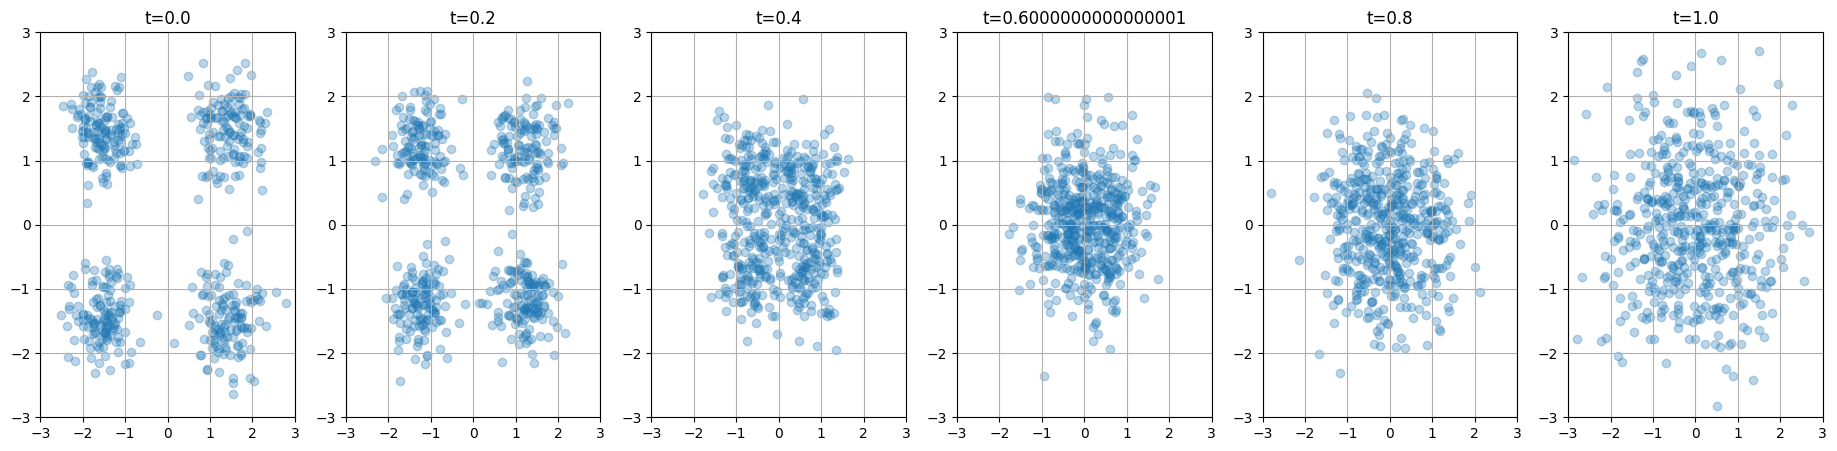

In [29]:
seed = 0
np.random.seed(seed)
key = random.PRNGKey(seed)
bs = 512
t_axis = np.linspace(0.0, 1.0, 6)

plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs), t_axis[i])
  plt.scatter(x_t[:,0], x_t[:,1], alpha=0.3)
  plt.title(f't={t_axis[i]}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()

#### 🧠Intuition: Why 4 Gaussians "merge"

Each sample, from one of the Gaussians, is diffused independently

- But the diffusion process acts identically on all points.
- As noise increases, the structure between clusters disappears.
- The plot shows that all 4 clusters gradually spread and overlap — eventually forming an approximate isotropic Gaussian blob.

📈 You are watching the GMM get corrupted into a standard Gaussian.



# 3. Why This Matters for Images (and Manifolds)

##### A. Analogy:
- Think of GMMs as simplified multimodal datasets.
- In images: different clusters = different digits, objects, classes.
- The data lies on a complex manifold (structured space).

##### B. In Diffusion Models
- The forward process destroys structure (maps manifold → noise).
- The reverse process learns to recover structure (noise → manifold).
- Your toy example shows this exactly — from multi-Gaussian to Gaussian blob.


In [11]:
class MLP(nn.Module):
  num_hid : int
  num_out : int

  @nn.compact
  def __call__(self, t, x):
    h = jnp.hstack([t,x])
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.relu(h)
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(features=self.num_out)(h)
    return h

In [12]:
model = MLP(num_hid=512, num_out=x_t.shape[1])
print(model)

key, init_key = random.split(key)
optimizer = optax.adam(learning_rate=2e-4)
state = train_state.TrainState.create(apply_fn=model.apply,
                                      params=model.init(init_key, np.ones([bs,1]), x_t),
                                      tx=optimizer)

MLP(
    # attributes
    num_hid = 512
    num_out = 2
)


## Loss Function

In general, the loss looks like this
$$\text{Loss} = \frac{1}{N}\sum_{i=1}^N\int dt\;\int dx\;\Vert v_t(x;\theta) - v_t^i(x)\Vert^2\,.$$
However, we rewrite it a bit in terms of the score and parametrize the following quantity
$$\text{MLP}(t,x;\theta) = \sigma_t\nabla_x\log q_t(x)\,.$$

In [13]:
def sm_loss(state, key, params, bs):
    keys = random.split(key, )
    sdlogqdx = lambda _t, _x: state.apply_fn(params, _t, _x)
    data = data_generator(keys[0], bs)
    t = random.uniform(keys[1], [bs,1])
    eps, x_t = q_t(keys[2], data, t)
    loss = ((eps + sdlogqdx(t, x_t))**2).sum(1)
    return loss.mean()

def sm_loss(state, key, params, bs):
  keys = random.split(key, )
  sdlogqdx = lambda _t, _x: state.apply_fn(params, _t, _x)
  data = sample_data(keys[0], bs)
  t = random.uniform(keys[1], [bs,1])
  eps, x_t = q_t(keys[2], data, t)
  loss = ((eps + sdlogqdx(t, x_t))**2).sum(1)
  print(loss.shape, 'final.shape', flush=True)
  return loss.mean()

@partial(jax.jit, static_argnums=1)
def train_step(state, bs, key):
  grad_fn = jax.value_and_grad(sm_loss, argnums=2)
  loss, grads = grad_fn(state, key, state.params, bs)
  state = state.apply_gradients(grads=grads)
  return state, loss

key, loc_key = random.split(key)
state, loss = train_step(state, bs, loc_key)

(512,) final.shape


## Train Loop

In [14]:
num_iterations = 20_000

loss_plot = np.zeros(num_iterations)
key, loop_key = random.split(key)
for iter in trange(num_iterations):
  state, loss = train_step(state, bs, random.fold_in(loop_key, iter))
  loss_plot[iter] = loss

100%|██████████| 20000/20000 [00:41<00:00, 487.62it/s]


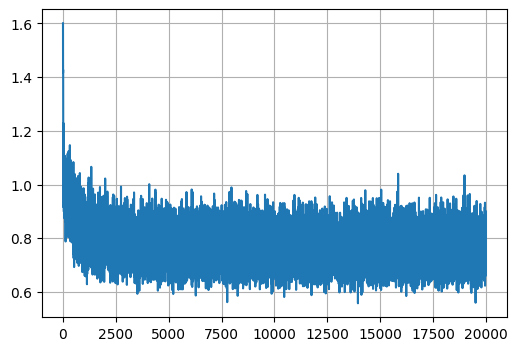

In [15]:
plt.figure(figsize=(6,4))
plt.plot(loss_plot)
plt.grid()

## Evaluation of the Trained Model

For the evaluation we simply sample from $q_{t=1}$ and propogate samples back in time according to the ODE
$$\frac{dx}{dt} = v_t(x)\,,\;\;\; v_t(x) = x\frac{\partial}{\partial t}\log\alpha_t - \beta_t\nabla_x\log q_t(x)\,,\;\;\beta_t = \sigma_t^2\frac{\partial}{\partial t}\log \frac{\sigma_t}{\alpha_t}\,,$$
or SDE
$$dx = (v_t(x) + \xi_t\nabla_x\log q_t(x))\cdot dt + \sqrt{2\xi_t}dW_t\,.$$

In [16]:
# v_t(x) = dlog(alpha)/dt x - s^2_t d/dt log(s_t/alpha_t) dlog q_t(x)/dx
@jax.jit
def vector_field(t,x,xi=0.0):
  sdlogqdx = lambda _t, _x: state.apply_fn(state.params, _t, _x)
  dxdt = dlog_alphadt(t)*x - beta(t)*sdlogqdx(t, x) - xi*beta(t)/jnp.exp(log_sigma(t))*sdlogqdx(t, x)
  return dxdt

In [17]:
dt = 1e-2
xi = 1.0
t = 1.0
n = int(t/dt)
t = t*jnp.ones((bs,1))
key, ikey = random.split(key, num=2)
x_gen = jnp.zeros((bs,n+1,x_t.shape[1]))
x_gen = x_gen.at[:,0,:].set(random.normal(ikey, shape=(bs, x_t.shape[1])))
for i in trange(n):
  key, ikey = random.split(key, num=2)
  dx = -dt*vector_field(t, x_gen[:,i,:], xi) + jnp.sqrt(2*xi*beta(t)*dt)*random.normal(ikey, shape=(bs,2))
  x_gen = x_gen.at[:,i+1,:].set(x_gen[:,i,:] + dx)
  t += -dt

100%|██████████| 100/100 [00:01<00:00, 58.88it/s]


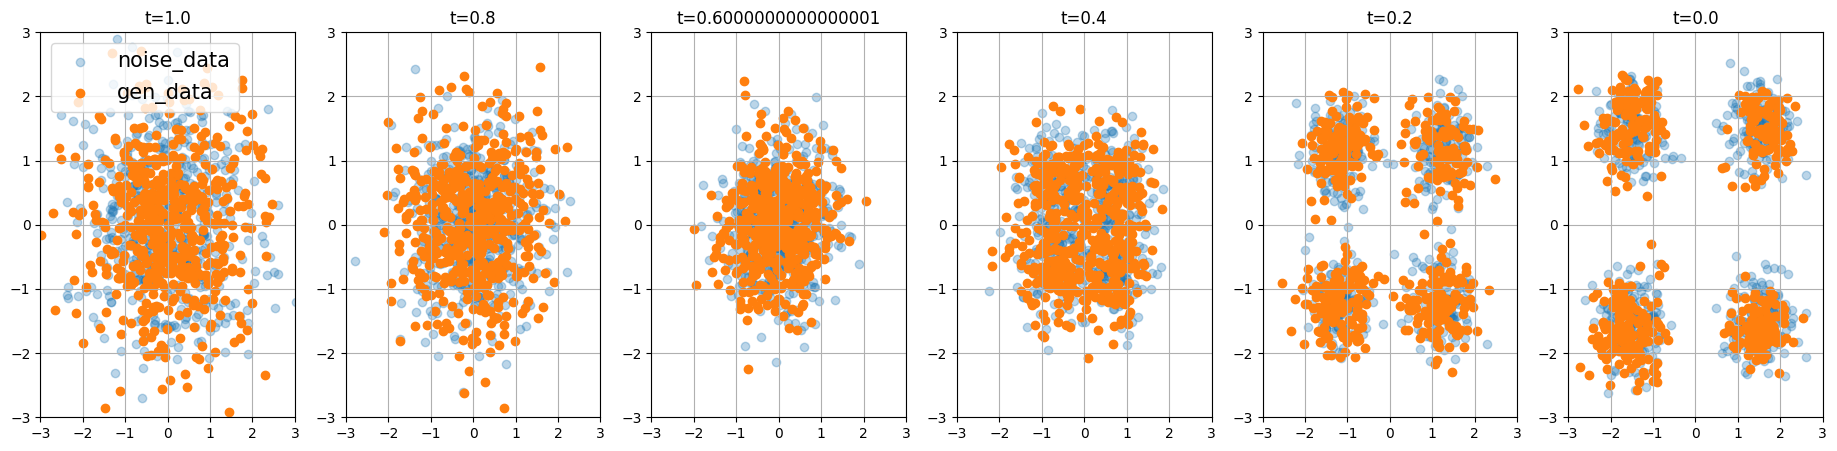

In [18]:
plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data', alpha=0.3)
  plt.scatter(x_gen[:,int(n*(t_axis[i])),0], x_gen[:,int(n*(t_axis[i])),1], label='gen_data')
  plt.title(f't={t}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)